In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
import model_sph as sph

# Spherical Jeans Code

This version of the Jeans code is currently tailor made for model Globular Cluster with a possible IMBH at its center, but it can easily modified for different objects as the integration of the spherical Jeans equation is independent of the model (within the assumption of constant velocity anisotropy) 

The main goal of the code is to solve the Jeans equation assuming a constant velocity anisotropy, which means it calculates the following integral:

\begin{equation*}
\langle \text{v}^2_r \rangle (r) = \frac{1}{n(r) r^{2\beta}}\int_{r}^{\infty}{dr'n(r')r'^{(2\beta)}\frac{\partial\Phi}{\partial r'}(r')}
\quad\quad\text{(1)}
\end{equation*}

where $n(r)$ is the tracer  number density (assumed to be the same as the luminosity density $j(r)$), $\beta$ is the radial velocity anisotropy and $\Phi$ is the potential

## Now, how does it work? 

The code create an object called ```model()``` which save all the parameters for the models ```pars```, the luminosity density (tracer density) ```self.nu```, the cumulative mass ```self.mass``` and radial velocity dispersion ```self.s2_r``` (as given by equation (1) )

```python

class model:
    
    def __init__(self,pars):
        self.I0,self.a1,self.a2,self.s0,self.s1,self.s2,self.alph_1,self.alph_2 = pars
         
        #par2
        self.r  = 10.**np.arange(-3.,8.0,0.1)
        self.nu = np.zeros((self.r).size)    
    
        #par3
        self.ml  = 0.0
        self.Mbh = 0.0
        self.mass = np.zeros((self.r).size)
    
        #par4
        self.beta = 0.0
        self.r_02 = 10.**np.arange(-2.,6.5,0.1)
        self.s2_r = np.zeros((self.r_02).size)    

```

```self.r``` is the radii range for $r'$ in equation (1) and it defines the range of raddi for the tracer density ```self.nu``` and cumulative mass ```self.mass```

In the current version the input parameters ```pars``` are given for the functional form of the surface brightness of the tracers, following this parametric form:

\begin{equation*}
I(R) = I_{0}\times(R/a_0)^{-s_0}\times(1+(R/a_0)^{\alpha_1})^{-s_1/\alpha_1}\times(1+(R/a_1)^{\alpha_2})^{-s_2/\alpha_2}
\quad\quad\text{(2)}
\end{equation*}



where $R$ is the projected radius. For this example I will use a combination of parameters that its consistent with a Plummer profile with a total mass of $M_{tot}=10^5\,M_{\odot}$, a scale radius of $r_0 = 2\,\text{[pc]}$ and a mass-to-light radius of $M/L = 1.5\,[M_{\odot}/L_{\odot}]$

The input parameters of equation (2) for this model are: 
(don't ask why)

In [4]:
I0     = 10**(3.72181614) 
a0     = 1.0
a1     = 1.99336662
s0     = 0.0
s1     = 0.0
s2     = 3.99616881
alph_1 = 1.0
alph_2 = 1.96685881

pars = [I0,a0,a1,s0,s1,s2,alph_1,alph_2]

### First step: ```model```

First step, create a model object:

In [5]:
M00 = sph.model(pars)

```M00``` now is the object that will have the input parameters and profiles, you can use ```M00.get_pars()``` to recover the input parameters

In [6]:
M00.get_pars()

[5270.0670416417615, 1.0, 1.99336662, 0.0, 0.0, 3.99616881, 1.0, 1.96685881]

### Second step: ```gen_nu()```
The second step is to generate the tracer density using the method ```gen_nu()```

In [7]:
M00.gen_nu()

/Users/farospin/Desktop/Jeans-models/model_sph.py:59: RuntimeWarning: invalid value encountered in reciprocal
  aux_03 = (-s2)*(1.+(R/a2)**(alph_2))**(-1.)*(R/a2)**(alph_2-1.)*(1./a2)
/Users/farospin/Desktop/Jeans-models/model_sph.py:57: RuntimeWarning: invalid value encountered in reciprocal
  aux_01 = (-s0)*(R/a1)**(-1.)*(1./a1)


```gen_nu()``` generates the tracer density (light) and saves it in ```self.nu```. In practice it's not really relevant as you can change the inner part of the code in whatever way you like. In this case the code deprojects the surface brightness calculating this integral:

\begin{equation*}
j(r) = \frac{-1}{\pi}\displaystyle\int_r^{\infty}{\frac{dR}{\sqrt{R^2-r^2}}\frac{dI}{dR}}
\quad\quad\text{(3)}\
\end{equation*}

Once $n(r)$ is created you can extract it by evaluating its value at any given point (within the constraints of the ```self.r```) using ```get_nu(r)```, in the same way you can recover the surface brightness at a given radius with ```I_surf(x)```. 

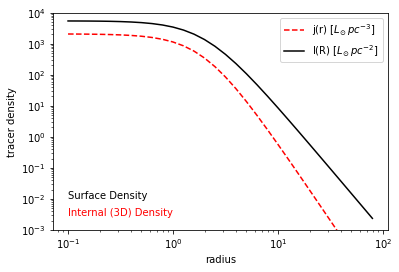

In [8]:
r = 10**np.arange(-1.,2.0,0.1)
R = 10**np.arange(-1.,2.0,0.1)

nu = np.zeros(r.size)
sb = np.zeros(R.size)

for k in range(r.size):
    nu[k] = M00.get_nu(r[k])
    
for k in range(R.size):
    sb[k] = M00.I_surf(R[k])


##Lets see the tracer density profiles:

fig,ax = plt.subplots(1,1,sharex=True)

ax.plot(r,nu,'--r',label=r'j(r) [$L_{\odot}\,pc^{-3}$]')
ax.plot(R,sb,'-k' ,label=r'I(R) [$L_{\odot}\,pc^{-2}$]')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('radius')
ax.set_ylabel('tracer density')

ax.text(0.1,0.01 ,'Surface Density',color='k')
ax.text(0.1,0.003,'Internal (3D) Density',color='r')

ax.set_ylim([1e-3,1e+4])

ax.legend()

plt.show()


### Third step: ```gen_mass(ml,mbh)```

The third step is to generate the cumulative mass profile for the potential. This method uses the already sampled tracer density ```self.nu```, the mass-to-light ratio ```self.ml``` and the mass of the central black hole ```self.Mbh```. The latter two are defined acording the input parameters given to the method. 

In the spherically symetric case, the gradient of the potential $d \Phi/d r$ is given directly by the enclosed mass as:

\begin{equation*}
\frac{d\Phi}{dr} = \frac{GM(r)}{r^2}
\quad\quad\text{(4)}\
\end{equation*}

The method is defined like this:

```python
def gen_mass(self,ml,Mbh):
        self.ml  = ml
        self.Mbh = Mbh
        
        I0,a1,a2,s0,s1,s2,alph_1,alph_2 = self.get_pars()
            
        r  = self.r
        aux_mass = np.zeros(r.size)
        
        for k in range(r.size-1):
    
            u = np.linspace(r[k],r[k+1],100)
            v = np.zeros(u.size)
    
            for j in range(u.size):
                v[j] = ml*self.get_nu(u[j])*u[j]**2
    
            du =      u[1:] - u[:u.size-1]
            dv = 0.5*(v[1:] + v[:v.size-1])
    
            aux_mass[k+1] = 4*np.pi*np.sum(du*dv)
        
        self.mass = np.cumsum(aux_mass) + Mbh
```

where it obtain the total mass by using a simple trapezoidal rule of numerical integration for the integral:

\begin{equation*}
M(r) = 4\pi\int_{0}^{r}\rho(r')r'^2 dr'
\quad\quad\text{(4)}\
\end{equation*}

As my code asumes a constant mass-to-light ratio then the mass density profile is described by ```ml*self.get_nu(u[j])```

We can generate the cumulative mass profile with the M/L = 1.5 and Mbh = 0.0

In [9]:
M00.gen_mass(1.5,0.0)

Then we can use ```get_mass(r)``` to extract values of the generated cumulative mass profile

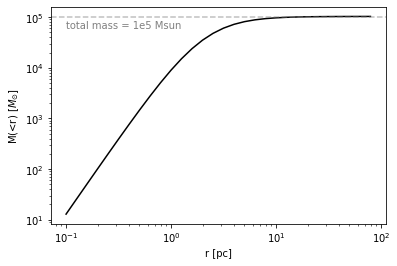

In [10]:
M = np.zeros(r.size)

for k in range(r.size):
    M[k] = M00.get_mass(r[k])
    
##Lets see the cumulative mass profile:

fig,ax = plt.subplots(1,1,sharex=True)

ax.plot(r,M,'-k')
ax.axhline(y=1e5,ls='--',c='0.5',alpha=0.5)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('r [pc]')
ax.set_ylabel('M(<r) [$M_{\odot}$] ')

ax.text(0.1,6e4,'total mass = 1e5 Msun',color='0.5')

plt.show()

### 4th step: ```gen_vdisp(ani)```

Now that the tracer density and the mass profile are generated and saved into the object ```M00``` we can integrate the Jeans equation (as eq. (1)). The method ```gen_vdisp(ani)``` receives as an argument a value of velocity anisotropy for the system, save it into the model and generate a radial profile for the square radial velocity dispersion.  

```python
    def gen_vdisp(self,beta):
        self.beta = beta
        r  = self.r_02
        
        for k in range(r.size):
            x  = r[k] + 10**np.arange(min3D,max3D,d3D)
            dx = x[1:x.size] - x[0:x.size-1]
            
            Ms = np.zeros(x.size)
            js = np.zeros(x.size)            

            for j in range(x.size):
                Ms[j] = self.get_mass(x[j])
                js[j] = self.get_nu(x[j])
            
            dx = x[1:x.size]-x[0:x.size-1]
            ds = js*x**(2.*beta-2)*G*Ms
            
            f_mid = 0.5*(ds[1:x.size]+ds[0:x.size-1])*dx
            
            self.s2_r[k] = np.sum(f_mid)*(self.get_nu(r[k]))**(-1)*(r[k])**(-2*beta)
```

As the other ```gen_``` methods, this one also don't return anything as save the profile directly on the object. Note also that it uses a different radial range than ```self.nu``` and ```self.mass```, the radial range for these two (```self.r```) is larger than ```self.r_02``` wich is the radial range for ```self.s2_r```. Note also that it uses the cumulative mass profile instead of the potential, in this case eq. (1) becomes:

\begin{equation*}
\langle \text{v}^2_r \rangle (r) = \frac{1}{n(r) r^{2\beta}}\int_{r}^{\infty}{dr'n(r')r'^{(2\beta)}\frac{GM(r')}{r'^2}}
\quad\quad\text{(5)}
\end{equation*}

For the isotropic case $\beta=0.0$ we have then:

In [11]:
M00.gen_vdisp(0.0)

In the same way as for the others we can use ```get_s2r(r)``` to get the velocity dispersion at any radius (within the limits of ```self.r_02```)

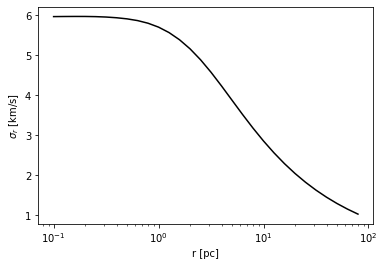

In [12]:
Sr = np.zeros(r.size)

for k in range(r.size):
    Sr[k] = M00.get_s2r(r[k])**0.5
    
##Lets see the cumulative mass profile:

fig,ax = plt.subplots(1,1,sharex=True)

ax.plot(r,Sr,'-k')

ax.set_xscale('log')

ax.set_xlabel(r'r [pc]')
ax.set_ylabel(r'$\sigma_r$ [km/s] ')

plt.show()

### 5th step: Projection on the sky ```I_surf(R)```, ```s_los(R)``` and ```s_pms(R)```

The code has three methods to project the internal (3D) quantities into the sky. These method do a integration along the line-of-sight, the simple case is for the tracer density (in this case light, i.e. luminosity surface density)

```I_surf(R)``` calculates the following integral at a given projected radius $R$ in the sky (from the center of the cluster,galaxy ... etc). The method was used when introducing the calculation of the tracer density on step 2.

\begin{equation*}
I(R) = 2\int_{R}^{\infty}{\frac{r dr}{\sqrt{r^2-R^2}}j(r)}
\quad\quad\text{(6)}
\end{equation*}

```python
def I_surf(self,x):
        r  = x + 10**np.arange(minPJ,maxPJ,dPJ)
        dr = r[1:] - r[:r.size-1] 

        js  = np.zeros(r.size)
        for j in range(r.size):
            js[j]  = self.get_nu(r[j])
    
        #integrando Slos
        A  = r/(r**2-x**2)**0.5*js
        dI = 0.5*(A[1:]+A[:r.size-1])*dr

        #results
        return 2*np.sum(dI)
```

```s_los(R)``` and ```s_pms(R)``` follow the same general integral, but with different projection of the velocity dispersion component (see eq. 18 of [van der Marel & Anderson (2010)](https://ui.adsabs.harvard.edu/abs/2010ApJ...710.1063V/abstract), ... or the projections bellow)

\begin{equation*}
\langle\text{v}^2_{\text{PROJ}}\rangle(R)  = \frac{1}{I(R)}\displaystyle\int_{R}^{\infty} \frac{j(r) 2r dr}{\sqrt{r^2-R^2}}\sigma_{PROJ}^2
\quad\quad\text{(7)}
\end{equation*}

where $\sigma^2_{PROJ}$ is given by:

\begin{align}
\sigma_{los}^2 & = \left(1-\beta\times(r/R)^2\right)\langle\text{v}^2_{r}\rangle\ \\
\sigma_{pmr}^2 & = \left(1-\beta+\beta\times(r/R)^2\right)\langle\text{v}^2_{r}\rangle\ \\
\sigma_{pmt}^2 & = \left(1-\beta\right)\langle\text{v}^2_{r}\rangle\
\end{align}

The methods are as follow:

```python
    def s_los(self,x):
        r  = x + 10**np.arange(minPJ,maxPJ,dPJ)
        dr = r[1:] - r[:r.size-1]
    
        s2r = np.zeros(r.size)
        js  = np.zeros(r.size)
    
        for j in range(r.size):
            s2r[j] = self.get_s2r(r[j])
            js[j]  = self.get_nu(r[j])
    
        #integrando Slos
        A = r/(r**2-x**2)**0.5*js
        B = (1.-self.beta*(x/r)**2)*s2r
        f = A*B
    
        dSlos = 0.5*(f[1:]+f[:r.size-1])*dr
        dI    = 0.5*(A[1:]+A[:r.size-1])*dr
    
        #results
        Slos = np.sqrt(np.sum(dSlos)/np.sum(dI))
    
        return Slos
```

```python
def s_pms(self,x):
        r  = x + 10**np.arange(minPJ,maxPJ,dPJ)
        dr = r[1:] - r[:r.size-1]
    
        s2r = np.zeros(r.size)
        js  = np.zeros(r.size)
    
        for j in range(r.size):
            s2r[j] = self.get_s2r(r[j])
            js[j]  = self.get_nu(r[j])
        
        #integration along los
        A = r/(r**2-x**2)**0.5*js
        
        #projections:
        B_rad = (1.-self.beta*(1-(x/r)**2))*s2r
        B_tan = (1.-self.beta)*s2r 

        f_rad = A*B_rad
        f_tan = A*B_tan

        dS_rad = 0.5*(f_rad[1:]+f_rad[:-1])*dr
        dS_tan = 0.5*(f_tan[1:]+f_tan[:-1])*dr
    
        dI    = 0.5*(A[1:]+A[:-1])*dr
        
        #results
        S_rad = np.sqrt(np.sum(dS_rad)/np.sum(dI))
        S_tan = np.sqrt(np.sum(dS_tan)/np.sum(dI))
        
        return [S_rad,S_tan]
```

Now let's get the projected velocity dispersions

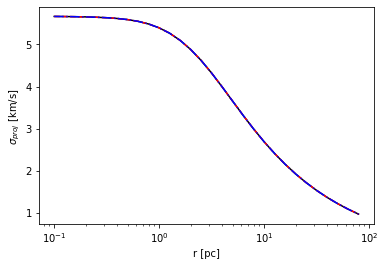

In [13]:
vd_los = np.zeros(R.size)
vd_pmr = np.zeros(R.size)
vd_pmt = np.zeros(R.size)


for k in range(R.size):
    vd_los[k]           = M00.s_los(R[k])
    vd_pmr[k],vd_pmt[k] = M00.s_pms(R[k])
   
    
##The plots are:

fig,ax = plt.subplots(1,1,sharex=True)

ax.plot(R,vd_los,'-k' ,label='los')
ax.plot(R,vd_pmr,'--r',label='pmr')
ax.plot(R,vd_pmt,'-.b',label='pmt')

ax.set_xscale('log')

ax.set_xlabel(r'r [pc]')
ax.set_ylabel(r'$\sigma_{proj}$ [km/s] ')

plt.show()

## What if we change the M$_{\rm bh}$ or the Anisotropy? 

In [14]:
Mtot, ML = 1e5,1.5

In [15]:
ex_mbh = np.array([0.,0.01,0.10])*Mtot  ## no black hole, 0.1% and 1.0%
ex_ani = np.array([-0.5,0.0,+0.5])      ## tangential, isotropic, radial

In [16]:
M01 = sph.model(pars)
M01.gen_nu()

/Users/farospin/Desktop/Jeans-models/model_sph.py:59: RuntimeWarning: invalid value encountered in reciprocal
  aux_03 = (-s2)*(1.+(R/a2)**(alph_2))**(-1.)*(R/a2)**(alph_2-1.)*(1./a2)
/Users/farospin/Desktop/Jeans-models/model_sph.py:58: RuntimeWarning: invalid value encountered in reciprocal
  aux_02 = (-s1)*(1.+(R/a1)**(alph_1))**(-1.)*(R/a1)**(alph_1-1.)*(1./a1)
/Users/farospin/Desktop/Jeans-models/model_sph.py:57: RuntimeWarning: invalid value encountered in reciprocal
  aux_01 = (-s0)*(R/a1)**(-1.)*(1./a1)


### CENTRAL BLACK HOLE

In [17]:
models_mbh = []

for k in range(ex_mbh.size):
    M01.gen_mass(ML,ex_mbh[k])
    M01.gen_vdisp(0.0) ##All isotropic
    
    aux_sr = np.zeros(r.size)
    
    for n in range(r.size):
        aux_sr[n] = M01.get_s2r(r[n])**2
    
    aux_slos = np.zeros(R.size)

    for n in range(R.size):
        aux_slos[n] = M01.s_los(R[n])
        
    models_mbh.append([aux_sr,aux_slos])


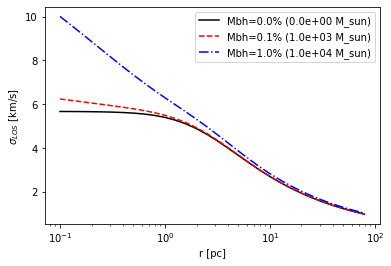

In [28]:
fig,ax = plt.subplots(1,1,sharex=True)

ax.plot(R,models_mbh[0][1],'-k' ,label='Mbh=0.0%% (%5.1e M_sun)'%(ex_mbh[0]))
ax.plot(R,models_mbh[1][1],'--r',label='Mbh=0.1%% (%5.1e M_sun)'%(ex_mbh[1]))
ax.plot(R,models_mbh[2][1],'-.b',label='Mbh=1.0%% (%5.1e M_sun)'%(ex_mbh[2]))

ax.set_xscale('log')

ax.legend()

ax.set_xlabel(r'r [pc]')
ax.set_ylabel(r'$\sigma_{LOS}$ [km/s] ')

plt.show()

### ANISOTROPY

In [19]:
models_ani = []

for k in range(ex_ani.size):
    M01.gen_mass(ML,0.0)      ##No Black Hole
    M01.gen_vdisp(ex_ani[k]) 
    
    aux_sr = np.zeros(r.size)
    for n in range(r.size):
        aux_sr[n] = M01.get_s2r(r[n])**2
    
    aux_slos = np.zeros(R.size)
    aux_spmr = np.zeros(R.size)
    aux_spmt = np.zeros(R.size)
    for n in range(R.size):
        aux_slos[n]             = M01.s_los(R[n])
        aux_spmr[n],aux_spmt[n] = M01.s_pms(R[n])
        
    models_ani.append([aux_sr,aux_slos,aux_spmr,aux_spmt])


/Users/farospin/Desktop/Jeans-models/model_sph.py:106: RuntimeWarning: invalid value encountered in reciprocal
  ds = js*x**(2.*beta-2)*G*Ms


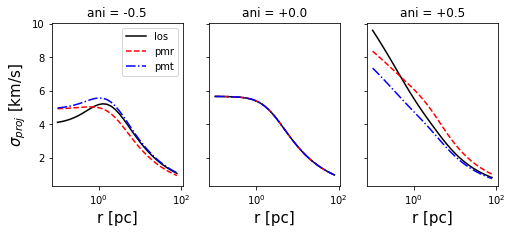

In [30]:
fig,ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(8,3))

for k in range(ex_ani.size):
    ax[k].plot(R,models_ani[k][1],'-k' ,label='los')
    ax[k].plot(R,models_ani[k][2],'--r',label='pmr')
    ax[k].plot(R,models_ani[k][3],'-.b',label='pmt')
    ax[k].set_xlabel(r'r [pc]',fontsize=15)
    ax[k].set_title('ani = %+4.1lf'%(ex_ani[k]))
    
ax[0].set_xscale('log')
ax[0].set_ylabel(r'$\sigma_{proj}$ [km/s] ',fontsize=15)
ax[0].legend()

plt.show()